## Introduction & Project Context ##
In finance, options are contracts that give the buyer the right, not the obligation, to buy or sell an underlying asset at a strike price on or before the expiration date. Among many, the two most common styles of option contracts are European and American. For European-style options, the contract can only be exercised at expiration, so the Black-Scholes PDE can be applied to find a closed-form solution for the price of the option. However, American-style options can be exercised anytime before expiration, which introduces an early exercise boundary. For this reason, no straightforward PDE can be solved to find a formula for the price of the option. 

There are several techniques for attempting to price American options, but for this project, I will be focusing on the widely used Monte-Carlo method called the **Longstaff-Schwartz algorithm**. As machine learning models become more advanced in their predictive power, I will be exploring how different ML models can be used to perform the regression within the LS algorithm for pricing American options.



## How the Longstaff-Schwartz algorithm works ##

The LS algorithm has several parameters regarding the initial behavior of the stock and conditions of the option contract:

- $S_0 = \text{Intial stock price}$
- $r = \text{Risk-Free interest rate}$
- $\sigma = \text{Volatility}$
- $T = \text{Time to expiration}$
- $K = \text{Strike price}$
- $n_{trials} = \text{number of simulated paths}$
- $n_{timesteps} = \text{number of timesteps per path}$

This algorithm uses Monte Carlo simulations to generate different potential paths that the underlying asset may go through. It leverages a backward recursive approach and regression to estimate the expected value of the option. The expected value is compared to the current exercise value to find the optimal payoff at each timestep. The average of all the simulated option prices is taken to determine the final price of the option.


In [1]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

RMSE = lambda data: np.sqrt(sum(([d*d for d in data])) / len(data))

def longstaff_schwartz(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, ml_model):
    """
    Core Longstaff-Schwartz implementation with ML models
    """
    # Monte-Carlo simulated paths
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    # Calculate terminal option prices
    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    # Use backward induction to find final option price 
    for t in range(n_timesteps-2,-1,-1):
        # Determine which paths are in-the-money and out-of-the-money
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        # If no paths are in-the-money, do not exercise any option
        if len(itm_indices[0]) == 0:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1) # Current stock prices for in-the-money paths
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt) # Discounted expected values of the option at the next timestep
        # Choose ML model
        match ml_model:
            case 'poly':
                # Degree 3 polynomial, random state for reproducibility
                model = make_pipeline(
                    PolynomialFeatures(degree=3),
                    LinearRegression(fit_intercept=False)
                )
                model.fit(X, y.ravel())
            case 'random forest':
                # Default hyperparameters, random state for reproducibility
                model = RandomForestRegressor(
                    random_state=42
                )
                model.fit(X, y.ravel())
            case 'xgboost':
                # Default hyperparameters, random state for reproducibility
                model = xgb.XGBRegressor(
                    random_state=42
                )
                model.fit(X, y)
            case 'mlp':
                # Default hyperparameters, random state for reproducibility
                model = MLPRegressor(
                    random_state=42
                )
                model.fit(X, y.ravel())
            case _:
                raise ValueError(f"Unknown model type: {ml_model}")
            
        future_val = model.predict(X).flatten() # Predicted discounted expected value
        
        # Calculate current exercise price
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        # Determines optimal time to exercise the option
        should_exercise = current_val > future_val
        # Sets payoffs accordingly
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)


    price = np.mean(payoffs[:,0]) # average of all option prices

    # 95% confidence interval
    SE = np.std(payoffs[:,0], ddof=1) / np.sqrt(n_trials)
    lower = price-1.96*SE
    upper = price+1.96*SE

    return price, lower, upper

## Choice of Models ##

In this project, I carefully chose four different machine learning approaches for the regression component within the Longstaff-Schwartz algorithm. For all models, the inputs are the stock prices for in-the-money paths only and the targets are discounted expected values of the option at the next timestep:

- **Polynomial Regression**
  - **Reason I chose this model:** This is the traditional baseline model that is typically implemented in the LS algorithm. It is computationally efficient, and should perform well in capturing the exercise boundary if it can be described by a polynomial.
  - **How it fits in the LS Algorithm:** At every timestep, the model tries to fit a polynomial of degree 3 for a function to find expected values of the option based on the current stock price. Predictions from this model come from the determined polynomial.
  
- **Random Forest**
  - **Reason I chose this model:** A random forest model could do a better job in this handling potential discontinuities that polynomial regression would not be able to handle. It can capture non-linear exercise boundaries without assuming an overall functional form.
  - **How it fits in the LS Algorithm:** At every timestep, the model creates several decision trees to categorize the expected value of the option based on the current stock price. It then averages the results from these trees for the final prediction.

- **XGBoost**
  - **Reason I chose this model:** This model could potentially be more efficient and robust than random forest. While both are ensemble algorithms, the sequential boosting in XGBoost could capture a lot more details that could be missed from the parallel bagging in random forest. Also, regularization will help model to avoid overfitting.
  - **How it fits in the LS Algorithm:** At every timestep, the model uses gradient boosting to sequentially add weak learners, each correcting previous errors to create a final robust learner. This final learner will be able to predict expected values of the option based on the current stock price. 

- **Multi-Layer Perceptron (MLP)**
  - **Reason I chose this model:** This model could theoretically outperform all other models given the correct hyperparameter tuning and regularization. Neural networks work well with large amounts of data, so using it in an algorithm that also uses Monte Carlo Simulation could have promising results.
  - **How it fits in the LS Algorithm:** At every timestep, layers of neurons are created, implicitly discovering its own relevant features and finding more nuanced patterns in the data. Then, using backpropagation, the MLP assigns weights to each neuron to create a universal function approximator capable of learning complex stock price to continuation value mappings.

For my benchmark, all ML-enhanced Longstaff-Schwartz results are compared against the **Binomial Tree model**, a widely accepted lattice-based pricing method that provides reliable American option valuations. This method starts at a root node with the value of $S_0$. A binary tree is created, branching into possible upward and downward paths at each step. Then, using backward induction, the option value at each node is calculated as the maximum of the immediate exercise value or the discounted expected future value based on risk-neutral probabilities.


In [2]:
def binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type):
    """
    Binomial Tree implementation for benchmark
    """
    stock_prices = [[S0]]
    dt = T / n_timesteps
    u = np.exp(sigma*np.sqrt(dt)) # upward branch multiplier
    d = 1/u # downward branch multiplier
    p = (np.exp(r*dt) - d) / (u - d) # probability of stock following the up branch 

    # Constructs tree by adding additionally factors of u and d to previous timestep
    for t in range(1,n_timesteps):
        new_prices = [ele*d for ele in stock_prices[-1]] + [S0 * (u**t)]
        stock_prices.append(new_prices)

    # Calculate terminal option prices
    if option_type == 'call':
        option_prices = [max(ele - K, 0) for ele in stock_prices[-1]]
    elif option_type == 'put':
        option_prices = [max(K - ele, 0) for ele in stock_prices[-1]]

    # Use backward induction to find final option price 
    for t in range(n_timesteps-2,-1,-1):
        # Consider current timestep and next timestep
        current_prices = [0]*(t+1)
        future_prices = option_prices
        for i in range(t+1):
            # Calculate current exercise price
            if option_type == 'call':
                exercise_val = max(stock_prices[t][i] - K, 0)
            elif option_type == 'put':
                exercise_val = max(K - stock_prices[t][i], 0)
            # Calculate discounted expected value through predetermined probabilities
            expected_val = ((p * future_prices[i+1]) + ((1-p) * future_prices[i])) * np.exp(-r*dt) 
            current_prices[i] = max(exercise_val,expected_val); # Determine optimal price for option
        option_prices = current_prices


    return option_prices[0]

*Side Note: The typical implementation of this method involves constructing a binary tree with depth $n_{timesteps}$, which results in a time and space complexity of $O(2^n)$. My implementation uses a list, and each element in the list is every possible stock value at the timestep. This yields a time and space complexity of $O(n^2)$, which makes the method much more efficient for large $n_{timesteps}$.*

## Testing Framework ##

In order to capture all patterns for how the models perform under varying data, I systematically chose different market conditions for a call option with $S_0 = 100$:

- $T_{test} = [0.25, 0.5, 1]$
    - To reflect option contracts with short, medium, and long maturities
- ${\sigma}_{test} = [0.15, 0.25, 0.4]$
    - To reflect underlying assests with low, medium, and high volatilities
- $K_{test} = [90, 100, 110]$
    - To reflect options that are out-of-the-money, at-the-money, and in-the-money
- $r_{test} = [0.01,0.03,0.05]$
    - To reflect market conditions with low, medium, and high risk-free rates

In [3]:
S0 = 100
n_trials = 100
n_timesteps = 100
option_type = 'call'

test_T = [0.25, 0.5, 1]
test_sigma = [0.15, 0.25, 0.4]
test_K = [90, 100, 110]
test_r = [0.01, 0.03, 0.05]
test_models = ['poly', 'random forest', 'xgboost', 'mlp']

Before collecting data, I created a new function to store the pricing results from all the models in a organized dicionary. 

In [4]:
def compare_models(S0, r, sigma, T, K, n_trials, n_timesteps, option_type):
    models = ['poly', 'random forest', 'xgboost', 'mlp']
    results = {}
    for model in models:
        price, lower, upper = longstaff_schwartz(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, model)
        results[model] = (price, lower, upper)
    return results

I stored all the results into a pandas DataFrame, including absolute and relative error from the LS algorithm compared to the binomial tree model.

In [5]:
from itertools import product
import pandas as pd


option_prices = pd.DataFrame(
    columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
)

# Add standard market conditions
for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
    results = compare_models(S0, r, sigma, T, K, n_trials, n_timesteps, option_type)
    binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
    for model in test_models:
        print(T, sigma, K, r, model)
        model_price, lower, upper = results[model]
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        option_prices.loc[len(option_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]

## Initial Results ##

After gathering the data, I used Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE), 2 different metrics to evalute the accuracy of these predictive models compare dot the binomial tree model.

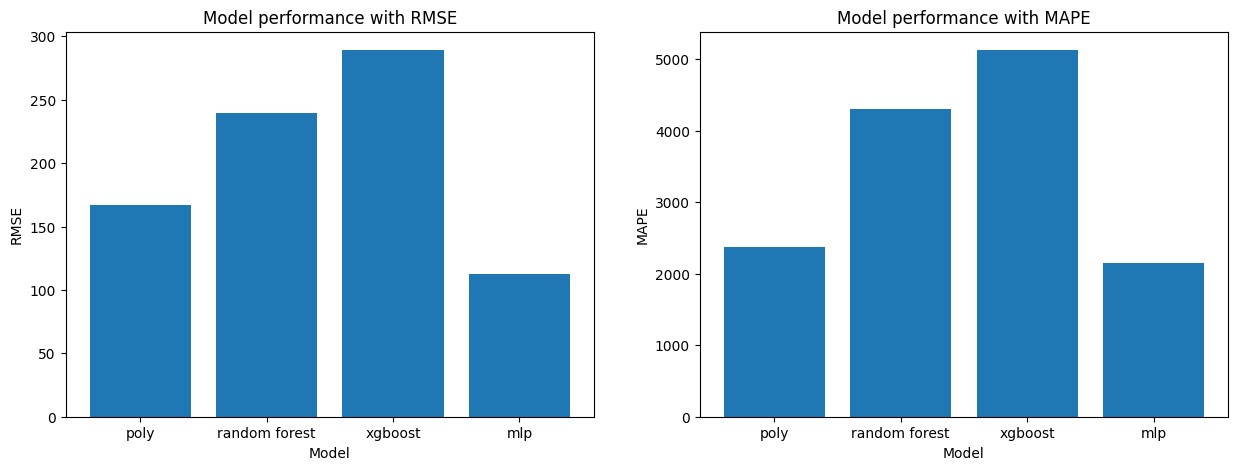

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

RMSE = lambda data: np.sqrt(sum(([d*d for d in data])) / len(data))
MAPE = lambda data: (sum([abs(d) for d in data])) / len(data)

RMSEs = {}
MAPEs = {}
for model in test_models:
    model_data = option_prices[option_prices['model'] == model]
    
    abs_error_data = model_data['Absolute Error']
    rel_error_data = model_data['Relative Error']


    RMSEs[model] = RMSE(abs_error_data)
    MAPEs[model] = MAPE(rel_error_data)

axes[0].bar(RMSEs.keys(), RMSEs.values())
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Model performance with RMSE')

axes[1].bar(MAPEs.keys(), MAPEs.values())
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAPE')
axes[1].set_title('Model performance with MAPE')
    

plt.show()

From these charts, I see very similar patterns. It seems that before and hyperparameter tuning or feature engineering, MLP is in the most accurate, followed by the original polynomial regression, followed by random forest, and then surprisingly, XGBoost is in last.

But a simple bar chart can't show all the important information the data has to offer. I used RMSE to evaluate the accuracy of these models compared to the binomial tree method. Run the following code cell to see the plots on the performance of each model under different conditions.

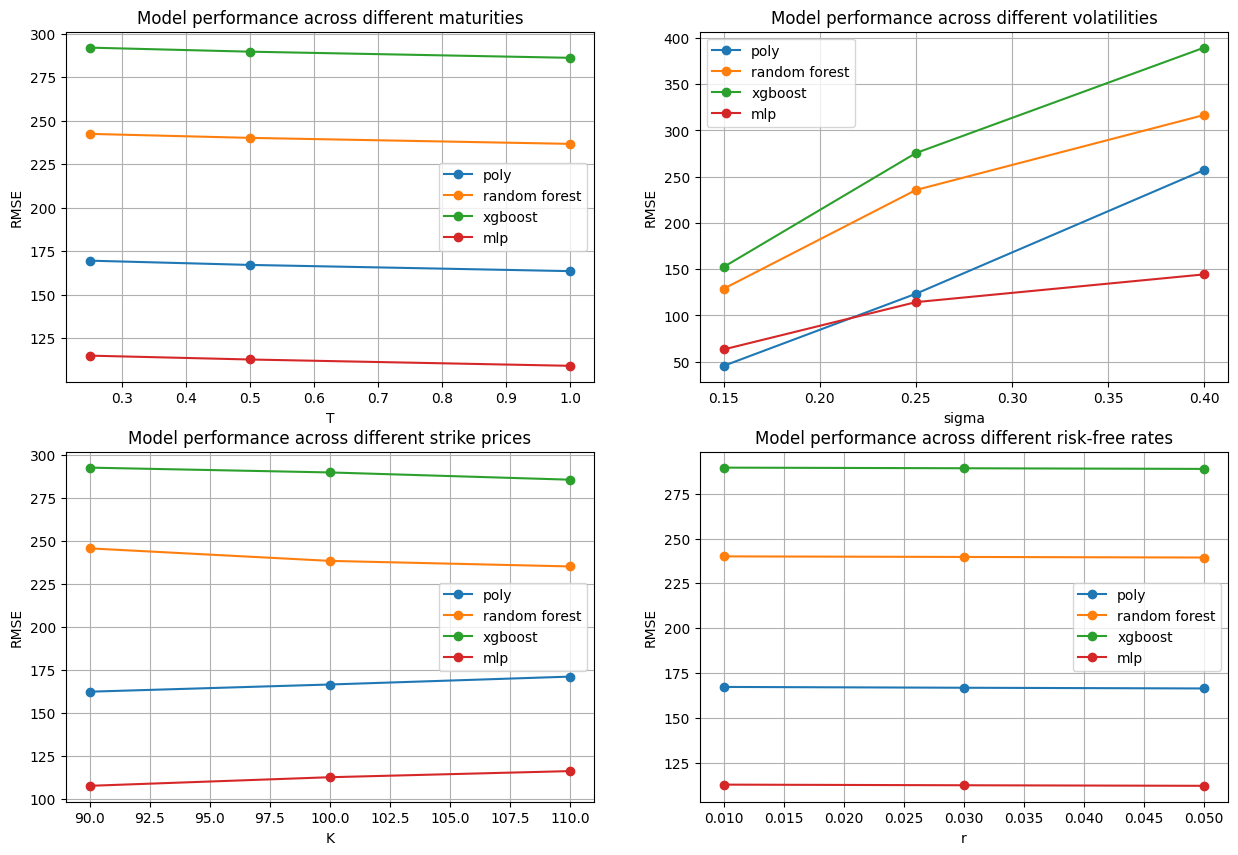

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

parameters = [test_T, test_sigma, test_K, test_r]
param_names = {'T': "maturities", 'sigma': "volatilities", 'K': "strike prices", 'r': "risk-free rates"}
i = 0

for metric, met_name in zip(parameters, param_names.keys()):
    for model in test_models:
        model_data = option_prices[option_prices['model'] == model]
        x = metric[:]
        abs_error_data = []
        for m in metric:
            insert = model_data[model_data[met_name] == m]['Absolute Error']
            abs_error_data.append(insert)
        y = [RMSE(data) for data in abs_error_data]
        axes[i].plot(x, y, label=model, marker='o') 
    axes[i].set_xlabel(met_name)
    axes[i].set_ylabel('RMSE')
    axes[i].set_title('Model performance across different ' + param_names[met_name])
    axes[i].legend() 
    axes[i].grid(True)  
    i+=1
    
plt.show()

It seems that for each model, there was no significant difference in accuracy when pricing options of different maturity, strike price, or risk-free interest rate. However, we can see that as volatility grew, every model grew increasingly innaccurate. This makes sense in context, as volatility drives pricing uncertainty, which would make it increasingly more difficult for the LS algorithm to accurately price options.

To ensure the differences in performance between the models is significant, I ran paired t-tests on the absolute error data for different combinations of models.

In [8]:
from scipy import stats

for i in range(len(test_models)):
    model1 = test_models[i]
    abs_error_data1 = option_prices[option_prices['model'] == model1]['Absolute Error']
    for j in range(i+1,len(test_models)):
        model2 = test_models[j]
        abs_error_data2 = option_prices[option_prices['model'] == model2]['Absolute Error']
        t_stat, p_value = stats.ttest_rel(abs_error_data1, abs_error_data2)
        print(model1 + ' vs ' + model2 + ' p-value: ' + str(p_value))

poly vs random forest p-value: 2.5498882001709854e-45
poly vs xgboost p-value: 4.2467023926038835e-66
poly vs mlp p-value: 1.1929216770614508e-06
random forest vs xgboost p-value: 4.5367362194912004e-32
random forest vs mlp p-value: 1.658458953257345e-38
xgboost vs mlp p-value: 4.335061661845494e-37


### Statistical Significance Analysis ###

The paired t-tests reveal that **all model performance differences are highly statistically significant** (p < 0.001), confirming that our observed performance rankings are not due to random chance. These results provide strong statistical foundation for our model selection decisions and hyperparameter optimization priorities moving forward.

## Model Behavior Analysis ##

To make sense of these results and increase the accuracy of the models, I analyzed possible reasons of why models behaved the way they did.

- **1st place: MLP (RMSE ~ 110)**
  - **Hyperparameter Analysis:** I used sklearn's default hyperparamaeters for this model, which seem to work surprisingly well.
    - The architecture was a **single hidden layer** with **100 neurons**. Having this large amount of neurons for just a single layer gives more than enough opportunities to approximate exercise boundary given that it is simple. However, if there are more complex patterns to be discovered, implementing a hierarchical architecture might be able to refine decisions and generalize better.
    - The activation function was **ReLU**. This is standard for MLPs, and I see no reason why any other activation function could be yield significantly better results, so I will keep this.
    - The learning rate is controled through an **Adam optimizer**. This solver approximates the gradient and adjusts the learning rate accordingly. I will stick with this, as is much more robust than a fixed learning rate. With this, I will also keep the **initial learning rate** to **0.001**, which is a low enough value for Adam not to explode.
    - The **maximum number of iterations** is **200**. When I run the LS algorithm with this low of a threshold, I tend to get warnings alerting me that the optmization has not stably converged, so the loss is not as minmized as it could be.
  - **Improvements**
    - I will change the architecture to have **more hidden layers** with **varying sizes**. 
    - I will experiment with **larger maximum number of iterations** to ensure convergence during training.
    - I will add **early stopping** to the MLP so that even if maximum number of iterations has not been met yet, it can prematurely stop the optimization process if loss has seemed to stabilize. I will use **Mean Squared Error** to determine early stopping requirements, basing it directly off of loss instead of R^2. I will further implement a **validation split** of 0.2 so that the MLP can use 20% of the data to track convergence.
    - I will try to **increase alpha** for L2 regularization to catch my model if it is overfitting from noise in the Monte Carlo simulations.

  
- **2nd place: Polynomial Regression (RMSE ~ 165)**
  - **Hyperparameter Analysis:** I intially only set two hyperparameters for the model.
    - I set the **degree of the polynomial** to **3**. I saw this value in other implementations for the LS algorithm, so I thought it would capture most of the exercise boundary without heavily overfitting.
    - I set **fit_intercept** to **false**. I had intially thought that there wouldn't be too much of a difference if I force the polynomial to go through 0, but now realizing that I have not centered my stock prices, which are the features of the model, I shouldn't assume to function passes through the origin.
  - **Improvements**
    - I will experiment with **different degrees for the polynomial** to see which one may result in the best fit. I will check polynomials with **degrees 2 to 6**, not going too high to prevent overfitting.
    - I will set **fit_intercept** to **true**. This will make the model learn an additional bias term (y-intercept), so the polynomial might be able to fit better with this axial leeway.  


- **3rd place: Random Forest (RMSE ~ 240)**
  - **Hyperparameter Analysis:** I used sklearn's default hyperparamaeters for this model.
    - The model used **100 trees** for bagging. This value is relatively low, which allows each iteration within the LS algorithm to run faster, but a larger forest might lead to better stability in results.
    - The trees themselves had **unlimited depth**, which means all the trees grew until they perfectly fit whatever subset of the training set they were trained on. This may lead to overfitting from noise in the various simulations.
  - **Improvements**
    - I will experiment with a **higher amount of trees** to see if it can stabilize the results.
    - I will **limit the depth of trees**. This could not only make the model run faster, but generalize better due to simplfied decision tree.
    - Since I only train my models off of one feature of stock price, I will set **max_features = 1**.
  

- **4th place: XGBoost (RMSE ~ 290)**
  - **Hyperparameter Analysis:** I used sklearn's default hyperparamaeters for this model.
    - The **learning rate** was at a constant **0.3**. Given all the noise in the Monte Carlo simulations, this is far too high for an appropriate learning rate.
    - The model used **100 trees** for boosting. This value is relatively low, which allows each iteration within the LS algorithm to run faster. However, if I decrease the learning rate, I should increase the amount of trees I use to restabilize my results.
    - The trees themselves had **max depth** of **6**. This is fine, but smaller trees may generalize slightly better.
    - **L1 Regularization** is **0** as default. Since I only have one feature, I will keep this value at 0.
    - **L2 Regularization** is **1** as default. It is difficult for me to quantify how much of my simulations are just noise, so I want to play with this value to see if I can further prevent my model from overfitting.
    - The **minimum loss reduction to split (gamma)** is **0.1**. This is another measure to control generalization of the model within trees.
    - The **fraction of training data per tree** is **1.0**, meaning all the data is being used. Given the scarcity of the ITM paths at every timestep, I am inclined to keep this value at 1.0, regardless if 1 or 2 paths might include noise.
    - The **fraction of features per tree** is **1.0.** I will keep this value, since I only have one feature.
  - **Improvements**
    - I will **decrease the learning rate**. With smaller steps towards minimizing the loss function, the path to convergece will be much more smooth, and less likely to overshoot the precise value the could be found from gradient descent.
    - I will experiment with a **higher amount of trees** to see if it can stabilize the results. However, I will optimize the efficiency of the model by adding **early stopping** to the model so it can prematurely stop the optimization process if loss has seemed to stabilize, which may eliminate the requirement to get rid of all trees.
    - I will try **lower fractions of training data per tree**.
    - I will experiment with **shallower trees** to see if a simplified tree architecture can generalize better to unseen data. 
    - I will experiment with **lower reg_lambda values** to smooth my predictions.
    - I will experiment with **different gamma values** to see how conservative I can make my model without negatively impacting its accuracy.

   

## Feature Engineering ##

After considering the structure of the LS algorithm, I determined that additional features beyond stock price would be redundant. Since I train a fresh model at each timestep, parameters like K, σ, r, and time remaining are constants within each training set. Therefore, any transformation of stock price (moneyness, Greeks proxies, etc.) provides no additional information beyond the raw stock price itself. This insight led me to focus optimization efforts on hyperparameter tuning rather than feature engineering, which is more appropriate for this problem structure.

## Hyperparameter Optimization ##

For each model, I will be looping through potential hyperparameters that I previously had predicted to increase the accuracy of the model. To do this, I will create modified implementations of my LS algorithm specifically designed to test these new hyperparameters. My goal is to minimize RMSE, which indicates a closer option price when compared to the binomial tree method. 

It is important to note that to maintaining the same random state for my models not ensures reproducibility in my results, but makes my tuning process deterministic and comparable across runs.

### XGBoost Analysis ###

For this analysis, I will be checking how the model accuracy is affected by 
- Number of Trees
  - $[50, 100, 150]$
- Early Stopping Rounds
  - $[20]$
- Maximum Tree Depth
  - $[3, 6]$
- Learning Rate
  - $[0.01, 0.1]$
- Fraction of Training Data used per Tree
  - $[0.7, 1.0]$
- Minimum loss reduction to split a node
  - $[0.1, 0.2]$
- Lambda (L2 Regularization)
  - $[0.25, 1.0]$

In [9]:
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'early_stopping_rounds': [20],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'gamma': [0.1, 0.2],
    'reg_lambda': [0.25, 1.0]
}

In [10]:
from sklearn.model_selection import train_test_split

def longstaff_schwartz_xgb(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid):
    """
    Core Longstaff-Schwartz implementation with variable XGBoost hyperparameters
    """
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    for t in range(n_timesteps-2,-1,-1):
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        if len(itm_indices[0]) < 10:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1)
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt)

        # Updated hyperparameters

        X_train, X_val, y_train, y_val = train_test_split(
            X, y.ravel(), 
            test_size=0.2, 
            random_state=42
        )
        n_estimators, early_stopping_rounds, max_depth, learning_rate, subsample, gamma, reg_lambda = param_grid
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,            
            learning_rate=learning_rate,         
            max_depth=max_depth,             
            reg_alpha=0, # Only 1 feature, keep at 0
            reg_lambda=reg_lambda,            
            gamma=gamma,                    
            subsample=subsample,      
            colsample_bytree=1, # Only 1 feature, keep at 1  
            early_stopping_rounds=early_stopping_rounds,  
            random_state=42
        )
        

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],   
            verbose=False              
        )
         
            
        future_val = model.predict(X).flatten() 
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        should_exercise = current_val > future_val
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)


    price = np.mean(payoffs[:,0])

    SE = np.std(payoffs[:,0], ddof=1) / np.sqrt(n_trials)
    lower = price-1.96*SE
    upper = price+1.96*SE

    return price, lower, upper

In [11]:
min_xgb_RMSE = RMSE(option_prices[option_prices['model'] == 'xgboost']['Absolute Error']) #initial RMSE without hyperparamter tuning
best_xgb_prices = None

param_list = list(product(
    xgb_param_grid['n_estimators'],
    xgb_param_grid['early_stopping_rounds'],
    xgb_param_grid['max_depth'],
    xgb_param_grid['learning_rate'],
    xgb_param_grid['subsample'],
    xgb_param_grid['gamma'],
    xgb_param_grid['reg_lambda'],
))

xgb_hyperparameter_data = pd.DataFrame(
    columns= (list(xgb_param_grid.keys()) + ['RMSE'])
) 

for param_grid in param_list:
    xgb_prices = pd.DataFrame(
        columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
    )  
    for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
        binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
        model = 'xgboost'
        model_price, lower, upper = longstaff_schwartz_xgb(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid)
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        xgb_prices.loc[len(xgb_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]
    rmse = RMSE(xgb_prices['Absolute Error'])
    if rmse < min_xgb_RMSE:
        min_xgb_RMSE = rmse
        best_xgb_prices = xgb_prices
    xgb_hyperparameter_data.loc[len(xgb_hyperparameter_data)] = list(param_grid) + [rmse]

print("XGBoost perfomance for different hyperparameters:")
xgb_hyperparameter_data

XGBoost perfomance for different hyperparameters:


,n_estimators,early_stopping_rounds,max_depth,learning_rate,subsample,gamma,reg_lambda,RMSE
0,50.0,20.0,3.0,0.01,0.7,0.1,0.25,74.230508
1,50.0,20.0,3.0,0.01,0.7,0.1,1.00,68.114506
2,50.0,20.0,3.0,0.01,0.7,0.2,0.25,74.230508
3,50.0,20.0,3.0,0.01,0.7,0.2,1.00,68.114506
4,50.0,20.0,3.0,0.01,1.0,0.1,0.25,71.167127
...,...,...,...,...,...,...,...,...
91,150.0,20.0,6.0,0.10,0.7,0.2,1.00,102.761976
92,150.0,20.0,6.0,0.10,1.0,0.1,0.25,123.013370
93,150.0,20.0,6.0,0.10,1.0,0.1,1.00,106.859477
94,150.0,20.0,6.0,0.10,1.0,0.2,0.25,122.411677


In [12]:
print("Best XGBoost Parameters:")
xgb_hyperparameter_data[xgb_hyperparameter_data['RMSE'] == min_xgb_RMSE]

Best XGBoost Parameters:


,n_estimators,early_stopping_rounds,max_depth,learning_rate,subsample,gamma,reg_lambda,RMSE
1,50.0,20.0,3.0,0.01,0.7,0.1,1.0,68.114506
3,50.0,20.0,3.0,0.01,0.7,0.2,1.0,68.114506


Contrary to my initial hypothesis, I found that using a lower amount of trees worked resulted in higher accuracy in my predictions. Additionally, the model performs best with shallow trees, a low learning rate, strong L2 regularization, and a rather conservative splitting limit. This pushes me to believe that this XGBoost model will be much more accurate given that is a simple, smooth model. While I initially thought having larger tree architectures would make the model more robust, it is apparent that the model performs worse, which indicates that there is a lot of noise that comes from the various Monte Carlo simulated paths.

My results suggest that the a simple model might perform better in options pricing. Therefore, I will rerun this experiment, testing hyperparamters to simplify the boosting process.

- Lower Number of Trees
  - $[5, 10, 18, 25, 50]$
- Same Early Stopping Rounds
  - $[20]$
- Lower Maximum Tree Depth
  - $[2, 3, 4]$
- Lower Learning Rate
  - $[0.001]$
- Lower Fraction of Training Data used per Tree
  - $[0.6, 0.8]$
- More Conservative Minimum loss reduction to split a node
  - $[0.1]$
- Stronger L2 Regularization
  - $[1.0, 2.0]$

In [13]:
xgb_param_grid = {
    'n_estimators': [5, 10, 18, 25, 50],
    'early_stopping_rounds': [20],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.001],
    'subsample': [0.6, 0.8],
    'gamma': [0.1],
    'reg_lambda': [1.0, 2.0]
}

In [14]:
min_xgb_RMSE = RMSE(option_prices[option_prices['model'] == 'xgboost']['Absolute Error']) #initial RMSE without hyperparamter tuning
best_xgb_prices = None

param_list = list(product(
    xgb_param_grid['n_estimators'],
    xgb_param_grid['early_stopping_rounds'],
    xgb_param_grid['max_depth'],
    xgb_param_grid['learning_rate'],
    xgb_param_grid['subsample'],
    xgb_param_grid['gamma'],
    xgb_param_grid['reg_lambda'],
))

xgb_hyperparameter_data = pd.DataFrame(
    columns= (list(xgb_param_grid.keys()) + ['RMSE'])
) 

for param_grid in param_list:
    xgb_prices = pd.DataFrame(
        columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
    )  
    for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
        binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
        model = 'xgboost'
        model_price, lower, upper = longstaff_schwartz_xgb(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid)
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        xgb_prices.loc[len(xgb_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]
    rmse = RMSE(xgb_prices['Absolute Error'])
    if rmse < min_xgb_RMSE:
        min_xgb_RMSE = rmse
        best_xgb_prices = xgb_prices
    xgb_hyperparameter_data.loc[len(xgb_hyperparameter_data)] = list(param_grid) + [rmse]

print("XGBoost perfomance for different hyperparameters:")
xgb_hyperparameter_data
       


XGBoost perfomance for different hyperparameters:


,n_estimators,early_stopping_rounds,max_depth,learning_rate,subsample,gamma,reg_lambda,RMSE
0,5.0,20.0,2.0,0.001,0.6,0.1,1.0,57.192541
1,5.0,20.0,2.0,0.001,0.6,0.1,2.0,57.156138
2,5.0,20.0,2.0,0.001,0.8,0.1,1.0,57.192541
3,5.0,20.0,2.0,0.001,0.8,0.1,2.0,57.198619
4,5.0,20.0,3.0,0.001,0.6,0.1,1.0,57.192541
5,5.0,20.0,3.0,0.001,0.6,0.1,2.0,57.156138
6,5.0,20.0,3.0,0.001,0.8,0.1,1.0,57.308632
7,5.0,20.0,3.0,0.001,0.8,0.1,2.0,57.251686
8,5.0,20.0,4.0,0.001,0.6,0.1,1.0,57.201704
9,5.0,20.0,4.0,0.001,0.6,0.1,2.0,57.156138


In [15]:
print("Best XGBoost Parameters:")
xgb_hyperparameter_data[xgb_hyperparameter_data['RMSE'] == min_xgb_RMSE]

Best XGBoost Parameters:


,n_estimators,early_stopping_rounds,max_depth,learning_rate,subsample,gamma,reg_lambda,RMSE
12,10.0,20.0,2.0,0.001,0.6,0.1,1.0,57.092266


From these results, it is evident that the lower amount of trees used, the better the model is at predicting option prices. Overall, prioritizing the training of a simple and smooth model seems to be the best strategy for minimizing RMSE between ML models and the binomial tree model. 

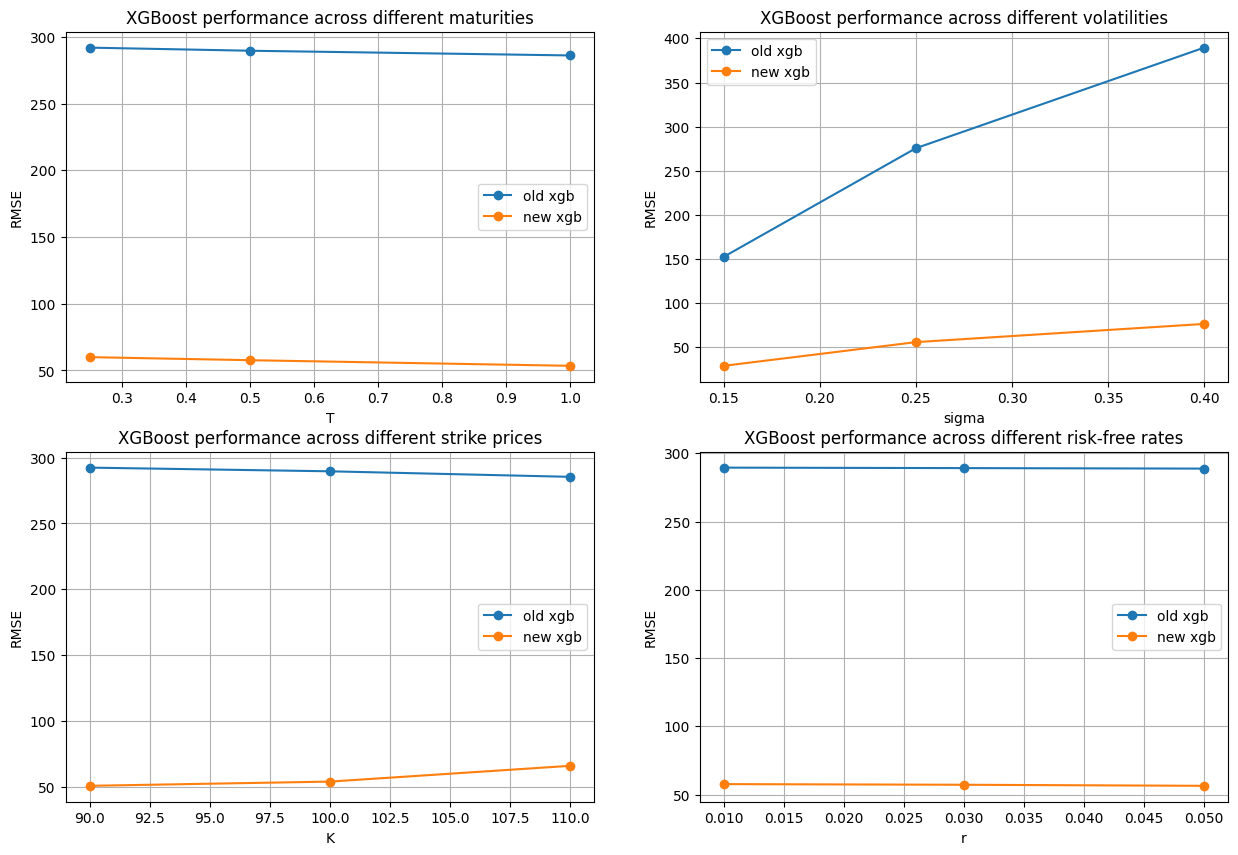

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

parameters = [test_T, test_sigma, test_K, test_r]
param_names = {'T': "maturities", 'sigma': "volatilities", 'K': "strike prices", 'r': "risk-free rates"}
i = 0

for metric, met_name in zip(parameters, param_names.keys()):
    model_data = option_prices[option_prices['model'] == 'xgboost']
    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = model_data[model_data[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='old xgb', marker='o') 

    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = best_xgb_prices[best_xgb_prices[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='new xgb', marker='o') 

    axes[i].set_xlabel(met_name)
    axes[i].set_ylabel('RMSE')
    axes[i].set_title('XGBoost performance across different ' + param_names[met_name])
    axes[i].legend() 
    axes[i].grid(True)  
    i+=1
    
plt.show()

With hyperparameter tuning for XGBoost, I was able to significantly decrease the RMSE across every market condition.

### Random Forest Analysis ###

For this analysis, I was initially planning on seeing how the model would run with a more complex architecture. However, from the results I found from XGBoost, I will focus on choosing hyperparameters to simplfy the model, as random forest models are even more prone to overfitting from the noise in the data. These are the hyperparameters I will be testing
- Number of Trees
  - $[5, 10, 25, 50]$
- Maximum Tree Depth
  - $[2, 3, 4]$
- Minimum samples per leaf node
  - $[1, 5, 10]$
- Minimum samples to split leaf node
  - $[2, 10, 20]$
- Maximum Trees used in Training
  - $[1]$

In [17]:
rf_param_grid = {
    'n_estimators': [5, 10, 25, 50],       
    'max_depth': [2, 3, 4],           
    'min_samples_leaf': [1, 5, 10],       
    'min_samples_split': [2, 10, 20],    
    'max_features': [1] 
}

In [18]:
def longstaff_schwartz_rf(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid):
    """
    Core Longstaff-Schwartz implementation with variable Random Forest hyperparameters
    """
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    for t in range(n_timesteps-2,-1,-1):
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        if len(itm_indices[0]) < 10:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1)
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt)

        # Updated hyperparameters
        n_estimators, max_depth, min_samples_leaf, min_samples_split, max_features = param_grid
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42
        )
        

        model.fit(X, y.ravel())
         
            
        future_val = model.predict(X).flatten() 
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        should_exercise = current_val > future_val
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)


    price = np.mean(payoffs[:,0])

    SE = np.std(payoffs[:,0], ddof=1) / np.sqrt(n_trials)
    lower = price-1.96*SE
    upper = price+1.96*SE

    return price, lower, upper

In [19]:
min_rf_RMSE = RMSE(option_prices[option_prices['model'] == 'random forest']['Absolute Error']) #initial RMSE without hyperparamter tuning
best_rf_prices = None

param_list = list(product(
    rf_param_grid['n_estimators'],
    rf_param_grid['max_depth'],
    rf_param_grid['min_samples_leaf'],       
    rf_param_grid['min_samples_split'],    
    rf_param_grid['max_features']
))

rf_hyperparameter_data = pd.DataFrame(
    columns= (list(rf_param_grid.keys()) + ['RMSE'])
) 

for param_grid in param_list:
    rf_prices = pd.DataFrame(
        columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
    )  
    for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
        binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
        model = 'random forest'
        model_price, lower, upper = longstaff_schwartz_rf(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid)
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        rf_prices.loc[len(rf_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]
    rmse = RMSE(rf_prices['Absolute Error'])
    if rmse < min_rf_RMSE:
        min_rf_RMSE = rmse
        best_rf_prices = rf_prices
    rf_hyperparameter_data.loc[len(rf_hyperparameter_data)] = list(param_grid) + [rmse]

print("Random Forest perfomance for different hyperparameters:")
rf_hyperparameter_data

Random Forest perfomance for different hyperparameters:


,n_estimators,max_depth,min_samples_leaf,min_samples_split,max_features,RMSE
0,5.0,2.0,1.0,2.0,1.0,168.618983
1,5.0,2.0,1.0,10.0,1.0,135.046463
2,5.0,2.0,1.0,20.0,1.0,76.722022
3,5.0,2.0,5.0,2.0,1.0,95.676046
4,5.0,2.0,5.0,10.0,1.0,95.676046
...,...,...,...,...,...,...
103,50.0,4.0,5.0,10.0,1.0,105.437847
104,50.0,4.0,5.0,20.0,1.0,77.334593
105,50.0,4.0,10.0,2.0,1.0,68.568924
106,50.0,4.0,10.0,10.0,1.0,68.568924


In [20]:
print("Best Random Forest Parameters:")
rf_hyperparameter_data[rf_hyperparameter_data['RMSE'] == min_rf_RMSE]

Best Random Forest Parameters:


,n_estimators,max_depth,min_samples_leaf,min_samples_split,max_features,RMSE
6,5.0,2.0,10.0,2.0,1.0,64.018867
7,5.0,2.0,10.0,10.0,1.0,64.018867
8,5.0,2.0,10.0,20.0,1.0,64.018867


From these hyperparameters, this further validates my claim that a simple model will do a better job at capturing the early exercise boundary. A smaller amount of trees with a larger minimum samples per leaf node allows the model to smooth out its predictions, which evidently results in higher accuracy. Since the optimal max depth is only 2, the values within min_samples_split become irrelevant.

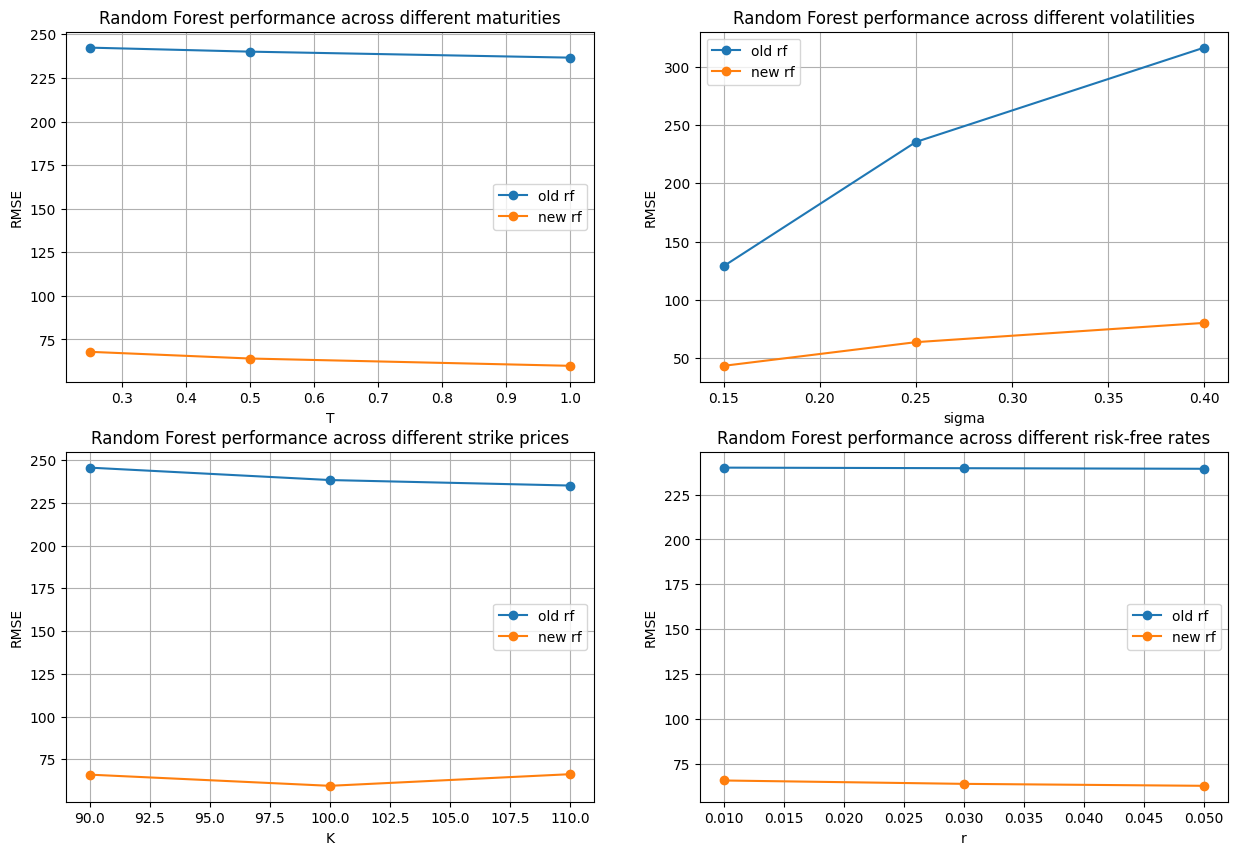

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

parameters = [test_T, test_sigma, test_K, test_r]
param_names = {'T': "maturities", 'sigma': "volatilities", 'K': "strike prices", 'r': "risk-free rates"}
i = 0

for metric, met_name in zip(parameters, param_names.keys()):
    model_data = option_prices[option_prices['model'] == 'random forest']
    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = model_data[model_data[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='old rf', marker='o') 

    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = best_rf_prices[best_rf_prices[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='new rf', marker='o') 

    axes[i].set_xlabel(met_name)
    axes[i].set_ylabel('RMSE')
    axes[i].set_title('Random Forest performance across different ' + param_names[met_name])
    axes[i].legend() 
    axes[i].grid(True)  
    i+=1
    
plt.show()

With hyperparameter tuning for random forest, I was able to significantly decrease the RMSE across every market condition.

### Polynomial Regression Analysis ###

For this analysis, the main relationship I will be testing is  I will be checking how the model accuracy is affected by 
- Degree of Polynomial
  - $[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]$
- Inclusion of Bias Term
  - $[\text{True}]$


In [22]:
poly_param_grid = {
    'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'fit_intercept': [True]
}

In [23]:
def longstaff_schwartz_poly(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid):
    """
    Core Longstaff-Schwartz implementation with variable Polynomial Regression hyperparameters
    """
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    for t in range(n_timesteps-2,-1,-1):
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        if len(itm_indices[0]) < 10:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1)
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt)

        # Updated hyperparameters
        degree, fit_intercept = param_grid
        model = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression(fit_intercept=fit_intercept) 
        )
        

        model.fit(X, y.ravel())
         
            
        future_val = model.predict(X).flatten() 
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        should_exercise = current_val > future_val
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)


    price = np.mean(payoffs[:,0])

    SE = np.std(payoffs[:,0], ddof=1) / np.sqrt(n_trials)
    lower = price-1.96*SE
    upper = price+1.96*SE

    return price, lower, upper

In [24]:
min_poly_RMSE = RMSE(option_prices[option_prices['model'] == 'poly']['Absolute Error']) #initial RMSE without hyperparamter tuning
best_poly_prices = None

param_list = list(product(
    poly_param_grid['degree'],
    poly_param_grid['fit_intercept']
))

poly_hyperparameter_data = pd.DataFrame(
    columns= (list(poly_param_grid.keys()) + ['RMSE'])
) 


for param_grid in param_list:
    poly_prices = pd.DataFrame(
        columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
    )  
    for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
        binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
        model = 'poly'
        model_price, lower, upper = longstaff_schwartz_poly(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid)
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        poly_prices.loc[len(poly_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]
    rmse = RMSE(poly_prices['Absolute Error'])
    if rmse < min_poly_RMSE:
        min_poly_RMSE = rmse
        best_poly_prices = poly_prices
    poly_hyperparameter_data.loc[len(poly_hyperparameter_data)] = list(param_grid) + [rmse]

print("Polynomial Regression perfomance for different hyperparameters:")
poly_hyperparameter_data


Polynomial Regression perfomance for different hyperparameters:


,degree,fit_intercept,RMSE
0,1,True,120.529905
1,2,True,147.442102
2,3,True,141.376424
3,4,True,159.227051
4,5,True,155.360865
5,6,True,158.604139
6,7,True,147.757534
7,8,True,143.771978
8,9,True,145.212642
9,10,True,173.361799


Since I am only testing degree of polynomial, I included a plot to visualize the accuracy of the models as it tried to fit different degree polynomials.

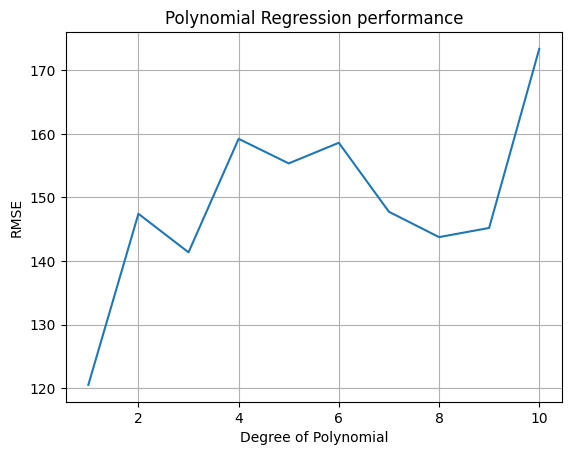

In [25]:
plt.plot(poly_param_grid['degree'], poly_hyperparameter_data['RMSE'])
plt.xlabel('Degree of Polynomial')
plt.ylabel('RMSE')
plt.title('Polynomial Regression performance')
plt.grid(True) 
plt.show()

In [26]:
print("Best Polynomial Regression Parameters:")
poly_hyperparameter_data[poly_hyperparameter_data['RMSE'] == min_poly_RMSE]

Best Polynomial Regression Parameters:


,degree,fit_intercept,RMSE
0,1,True,120.529905


The simplest polynomials with the lowest degrees do the best job at options pricing compared to more complex polynomials. This is another piece of evidence that leads me to believe the the Monte Carlo simulations have a lot of noise in them, so higher degree polynomials would need to try harder to fit the insignificant complexities in the graph.

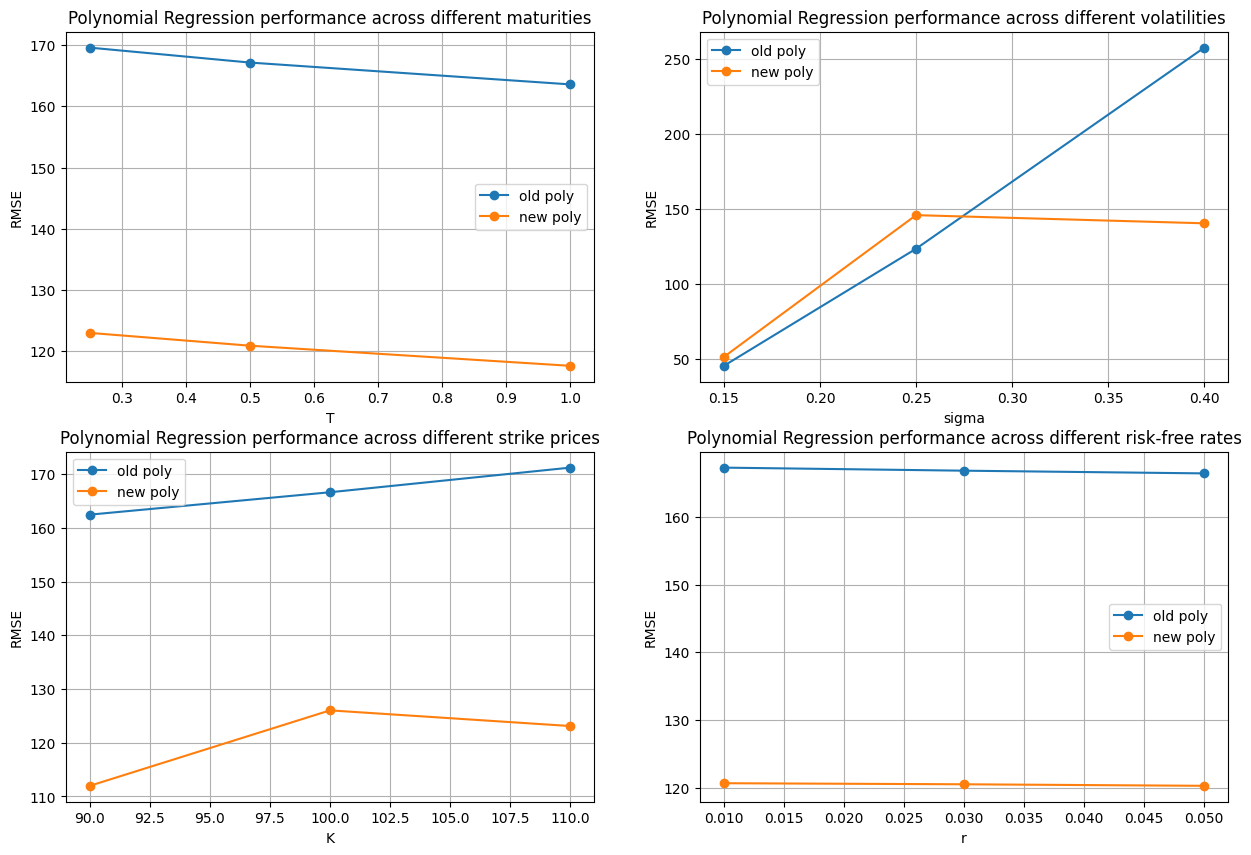

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

parameters = [test_T, test_sigma, test_K, test_r]
param_names = {'T': "maturities", 'sigma': "volatilities", 'K': "strike prices", 'r': "risk-free rates"}
i = 0

for metric, met_name in zip(parameters, param_names.keys()):
    model_data = option_prices[option_prices['model'] == 'poly']
    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = model_data[model_data[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='old poly', marker='o') 

    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = best_poly_prices[best_poly_prices[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='new poly', marker='o') 

    axes[i].set_xlabel(met_name)
    axes[i].set_ylabel('RMSE')
    axes[i].set_title('Polynomial Regression performance across different ' + param_names[met_name])
    axes[i].legend() 
    axes[i].grid(True)  
    i+=1
    
plt.show()

The tuned polynomial regression model performed better under different maturities, moneynesses, and risk-free rates. However, we see an intersting trend with volatility. For low/mid volatilties, the untuned model was good enough at capturing the early exercise boundary, as it was much more simple. This is why the difference between the RMSEs are almost neglibible. However, with higher volatilites, although this boundary became more complex, a higher degree polynomial, like the cubic polynomial used in the untuned model, overfit to the noise in the simulations. Therefore, the simpler, tuned model with a bias term drastically outperforms it.

### MLP Analysis ###

For this analysis, I would follow the same trend I have been doing by choosing hyperparameters to train a simple model. I could do this by lowering the maximum training epoch, but since MLP's require more data to converge to a stable model, I will keep this value high, but allow for early stopping. Furthermore, I will will be checking how the model accuracy is affected by 
- Neuron Architecture
  - $[(100), (64,64), (64,32,16)]$
- Alpha (L2 Regularization strength)
  - $[0.1, 1.0]$
- Maximum training epochs
  - $[500, 1000, 2000]$
- Initial Learning Rate
  - $[0.001, 0.01]$

In [28]:
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (64,64), (64,32,16)],  
    'alpha': [0.1, 1.0],
    'max_iter': [500, 1000, 2000],                      
    'learning_rate_init': [0.001, 0.01],             
}

In [29]:
def longstaff_schwartz_mlp(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid):
    """
    Core Longstaff-Schwartz implementation with variable MLP hyperparameters
    """
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    for t in range(n_timesteps-2,-1,-1):
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        if len(itm_indices[0]) < 10:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1)
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt)

        # Updated hyperparameters
        hidden_layer_sizes, alpha, max_iter, learning_rate_init = param_grid
        model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation='relu',
            solver='adam',
            alpha=alpha,
            early_stopping=True,
            validation_fraction=0.2,  
            tol=1e-4,    
            max_iter=max_iter,
            learning_rate_init=learning_rate_init,
            random_state=42
        )
        

        model.fit(X, y.ravel())
         
            
        future_val = model.predict(X).flatten() 
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        should_exercise = current_val > future_val
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)


    price = np.mean(payoffs[:,0]) 

    SE = np.std(payoffs[:,0], ddof=1) / np.sqrt(n_trials)
    lower = price-1.96*SE
    upper = price+1.96*SE

    return price, lower, upper

In [30]:
min_mlp_RMSE = RMSE(option_prices[option_prices['model'] == 'mlp']['Absolute Error']) #initial RMSE without hyperparamter tuning
best_mlp_prices = None

param_list = list(product(
    mlp_param_grid['hidden_layer_sizes'],
    mlp_param_grid['alpha'],
    mlp_param_grid['max_iter'],
    mlp_param_grid['learning_rate_init']
))

mlp_hyperparameter_data = pd.DataFrame(
    columns= (list(mlp_param_grid.keys()) + ['RMSE'])
) 

for param_grid in param_list:
    mlp_prices = pd.DataFrame(
        columns=['T', 'sigma', 'K', 'r', 'model', 'Model Price', 'Binomial Price', 'Lower', 'Upper', 'Absolute Error', 'Relative Error']
    )  
    for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
        binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
        model = 'mlp'
        model_price, lower, upper = longstaff_schwartz_mlp(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, param_grid)
        abs_error = abs(model_price-binomial_price)
        rel_error = (model_price-binomial_price) / binomial_price * 100
        mlp_prices.loc[len(mlp_prices)] = [T, sigma, K, r, model, model_price, binomial_price, lower, upper, abs_error, rel_error]
    rmse = RMSE(mlp_prices['Absolute Error'])
    if rmse < min_mlp_RMSE:
        min_mlp_RMSE = rmse
        best_mlp_prices = mlp_prices
    mlp_hyperparameter_data.loc[len(mlp_hyperparameter_data)] = list(param_grid) + [rmse]

print("MLP perfomance for different hyperparameters:")
mlp_hyperparameter_data

MLP perfomance for different hyperparameters:


,hidden_layer_sizes,alpha,max_iter,learning_rate_init,RMSE
0,"(100,)",0.1,500,0.001,39.494888
1,"(100,)",0.1,500,0.010,42.448216
2,"(100,)",0.1,1000,0.001,39.494888
3,"(100,)",0.1,1000,0.010,42.448216
4,"(100,)",0.1,2000,0.001,39.494888
5,"(100,)",0.1,2000,0.010,42.448216
6,"(100,)",1.0,500,0.001,39.512090
7,"(100,)",1.0,500,0.010,42.401689
8,"(100,)",1.0,1000,0.001,39.512090
9,"(100,)",1.0,1000,0.010,42.401689


In [31]:
print("Best MLP Parameters:")
mlp_hyperparameter_data[mlp_hyperparameter_data['RMSE'] == min_mlp_RMSE]

Best MLP Parameters:


,hidden_layer_sizes,alpha,max_iter,learning_rate_init,RMSE
18,"(64, 64)",1.0,500,0.001,33.235241
20,"(64, 64)",1.0,1000,0.001,33.235241
22,"(64, 64)",1.0,2000,0.001,33.235241


Early stopping allowed for the model to stop training for additional epochs after the stabilization of loss, which is why models with different number of trees had the same RMSE. By using a lower learning rate and number of training iterations, the MLP was trained to make more smooth predictions, which clearly dropped the RMSE by a large margin compared to the untuned model.

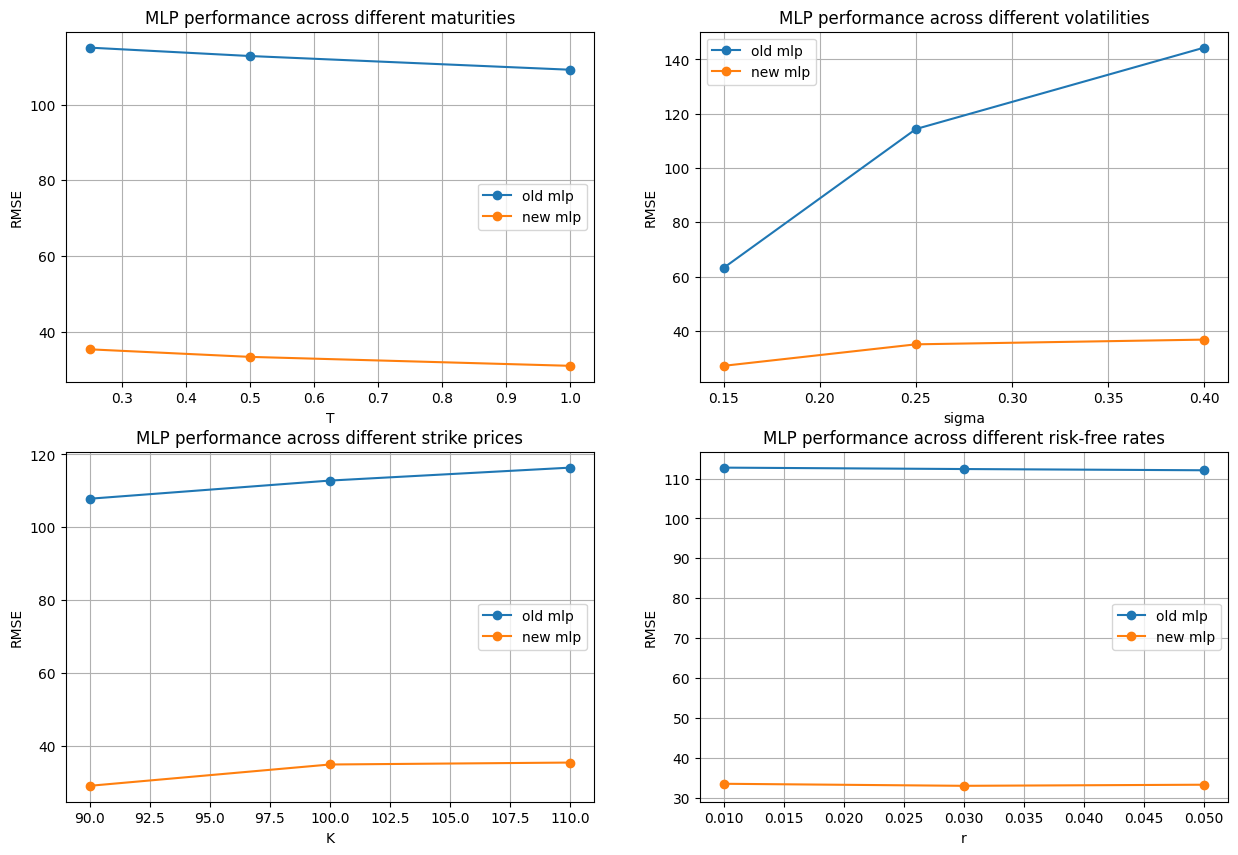

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

parameters = [test_T, test_sigma, test_K, test_r]
param_names = {'T': "maturities", 'sigma': "volatilities", 'K': "strike prices", 'r': "risk-free rates"}
i = 0

for metric, met_name in zip(parameters, param_names.keys()):
    model_data = option_prices[option_prices['model'] == 'mlp']
    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = model_data[model_data[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='old mlp', marker='o') 

    x = metric[:]
    abs_error_data = []
    for m in metric:
        insert = best_mlp_prices[best_mlp_prices[met_name] == m]['Absolute Error']
        abs_error_data.append(insert)
    y = [RMSE(data) for data in abs_error_data]
    axes[i].plot(x, y, label='new mlp', marker='o') 

    axes[i].set_xlabel(met_name)
    axes[i].set_ylabel('RMSE')
    axes[i].set_title('MLP performance across different ' + param_names[met_name])
    axes[i].legend() 
    axes[i].grid(True)  
    i+=1
    
plt.show()

## Hyperparameter Optimization Summary ##

Now that I have strategically tuned the hyperparameters for all my models, I can quantify how much I improved each model. 

In [33]:
optimization_summary = pd.DataFrame()

optimization_summary['Model'] = test_models
optimization_summary['Original RMSE'] = [RMSE(option_prices[option_prices['model'] == model]['Absolute Error']) for model in test_models]
optimization_summary['Optimized RMSE'] = [min_poly_RMSE, min_rf_RMSE, min_xgb_RMSE, min_mlp_RMSE]
optimization_summary['Absolute Improvement'] = optimization_summary['Original RMSE'] - optimization_summary['Optimized RMSE']
optimization_summary['Relative Improvement (%)'] = (optimization_summary['Absolute Improvement'] / optimization_summary['Original RMSE']) * 100
optimization_summary['Original Ranking'] = optimization_summary['Original RMSE'].rank(ascending=True).astype(int)
optimization_summary['New Ranking'] = optimization_summary['Optimized RMSE'].rank(ascending=True).astype(int)

optimization_summary

,Model,Original RMSE,Optimized RMSE,Absolute Improvement,Relative Improvement (%),Original Ranking,New Ranking
0,poly,166.801133,120.529905,46.271229,27.740356,2,4
1,random forest,239.725020,64.018867,175.706153,73.294875,3,3
2,xgboost,289.187754,57.092266,232.095488,80.257717,4,2
3,mlp,112.415376,33.235241,79.180135,70.435325,1,1


To visualize this improvement, I included side-by-side bar charts of the RMSEs for each model before and after tuning.

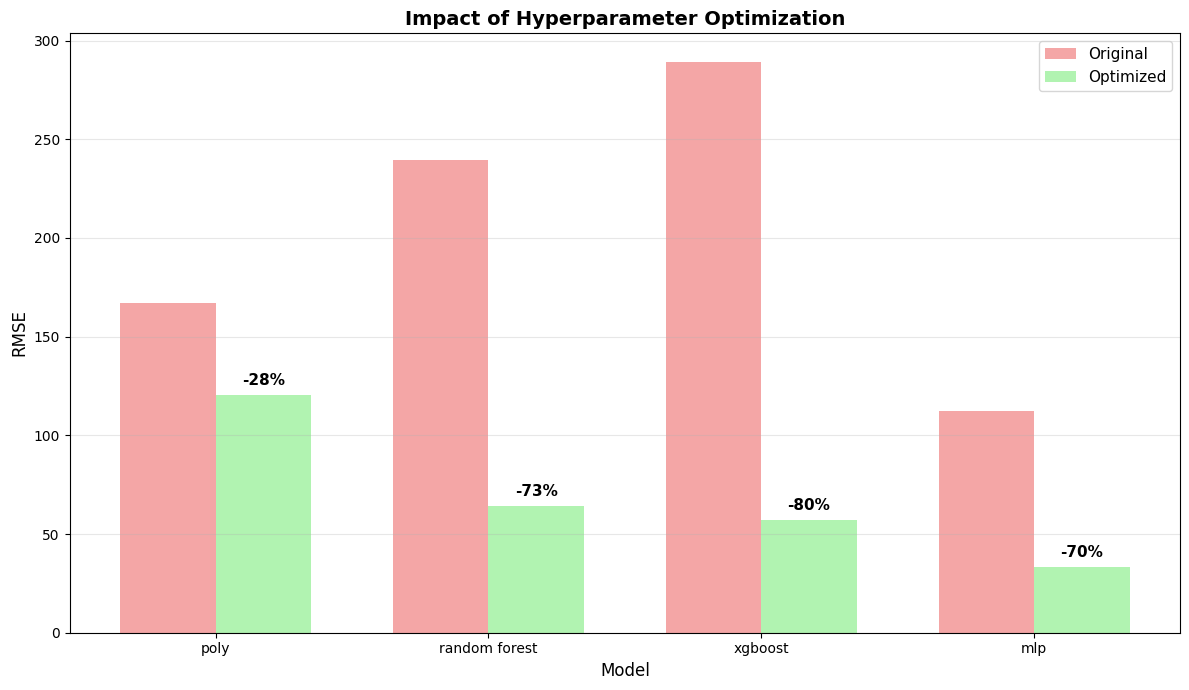

In [35]:
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(test_models))
width = 0.35

bars1 = ax.bar(x - width/2, optimization_summary['Original RMSE'], width, label='Original', alpha=0.7, color='lightcoral')
bars2 = ax.bar(x + width/2, optimization_summary['Optimized RMSE'], width, label='Optimized', alpha=0.7, color='lightgreen')

for i, (orig, opt) in enumerate(zip(optimization_summary['Original RMSE'], optimization_summary['Optimized RMSE'])):
    improvement = (orig - opt) / orig * 100
    ax.text(i + width/2, opt + 5, f'-{improvement:.0f}%', ha='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Impact of Hyperparameter Optimization', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(test_models)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

To ensure the hyperparameter tuning made statistically significant changes to the performances of the models, I ran paired t-tests on the absolute error data for the original and optimized version of each model.

In [36]:
best_prices = [best_poly_prices, best_rf_prices, best_xgb_prices, best_mlp_prices]

for model, data in zip(test_models, best_prices):
    original_errors = option_prices[option_prices['model'] == model]['Absolute Error']
    optimized_errors = data['Absolute Error'] 
    
    t_stat, p_value = stats.ttest_rel(original_errors, optimized_errors)
    effect_size = (original_errors.mean() - optimized_errors.mean()) / original_errors.std()
    
    print('Original ' + model + ' vs Optimized ' + model + ' p-value: ' + str(p_value))

Original poly vs Optimized poly p-value: 9.137636004425259e-05
Original random forest vs Optimized random forest p-value: 6.220257438244659e-38
Original xgboost vs Optimized xgboost p-value: 1.083145650704999e-39
Original mlp vs Optimized mlp p-value: 6.816556482604779e-36


### Statistical Significance Analysis ###

The paired t-tests reveal that **all model performance differences are highly statistically significant** (p < 0.001), confirming that our observed performance rankings are not due to random chance. These results provide strong statistical foundation for our model selection decisions and hyperparameter optimization priorities moving forward.

## Speed vs Accuracy Analysis ##

Of course, having accurate models is important for traders to make decisions. However, speed is also a large factor in implementing these models. When thousands of trades are occurring within a second, the ability to get **fast** and **accurate** results is of the utmost importance. For this reason, I will also explore how fast these tuned models can run, providing critical insights into how machine learning methods like these can be realistically implemented in quantitative finance.

I modified my implementation of the LS algorithm with the tuned models included. For models that resulted in the same RMSE for different combinations of hyperparameters, I chose the hyperparameters with the simplest architecture to maximize speed. I also added timers to understand how fast these versions of the model can be trained, and how fast they can predict continuation values.

In [42]:
import time

def longstaff_schwartz_time(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, ml_model):
    """
    Longstaff-Schwartz implementation to gather computational speed data
    """
    S = np.zeros((n_trials, n_timesteps))
    S[:,0] = S0
    rng = np.random.default_rng(42)
    dW = rng.normal(0, 1, (n_trials, n_timesteps))
    dt = T / n_timesteps
    for t in range(1,n_timesteps):
        S_t = S[:,t-1] 
        S[:,t] = S_t + r*S_t*dt + sigma*S_t*dW[:,t-1] 

    
    ST = S[:,n_timesteps-1]
    payoffs = np.zeros((n_trials, n_timesteps))

    if option_type == 'call':
        payoffs[:,n_timesteps-1] = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs[:,n_timesteps-1] = np.maximum(K - ST, 0)

    # Initialize time variables
    total_training_time = 0
    total_prediction_time = 0
    total_timesteps_with_training = 0

    for t in range(n_timesteps-2,-1,-1):
        if option_type == 'call':
            itm_indices = np.where(S[:,t] > K)
            otm_indices = np.where(S[:,t] <= K)
        elif option_type == 'put':
            itm_indices = np.where(S[:,t] < K)
            otm_indices = np.where(S[:,t] >= K)
        if len(itm_indices[0]) < 10:
            payoffs[:, t] = payoffs[:, t+1] * np.exp(-r*dt)
            continue
        X = S[itm_indices, t].reshape(-1, 1) 
        y = payoffs[itm_indices,t+1] * np.exp(-r*dt) 
        # Timer for training period
        start_train = time.perf_counter()
        match ml_model:
            case 'poly':
                model = make_pipeline(
                    PolynomialFeatures(degree=1),
                    LinearRegression(fit_intercept=True) 
                )
                model.fit(X, y.ravel())
            case 'random forest':
                model = RandomForestRegressor(
                    n_estimators=5,
                    max_depth=2,
                    min_samples_leaf=10,
                    min_samples_split=2,
                    max_features=1,
                    random_state=42
                )
                model.fit(X, y.ravel())
            case 'xgboost':
                X_train, X_val, y_train, y_val = train_test_split(
                    X, y.ravel(), 
                    test_size=0.2, 
                    random_state=42
                )
                model = xgb.XGBRegressor(
                    n_estimators=10,            
                    learning_rate=0.001,         
                    max_depth=2,             
                    reg_alpha=0, 
                    reg_lambda=1.0,            
                    gamma=0.1,                    
                    subsample=0.6,      
                    colsample_bytree=1, 
                    early_stopping_rounds=20,  
                    random_state=42
                )
                
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],   
                    verbose=False              
                )
            case 'mlp':
                model = MLPRegressor(
                    hidden_layer_sizes=(64, 64),
                    activation='relu',
                    solver='adam',
                    alpha=1.0,
                    early_stopping=True,
                    validation_fraction=0.2,  
                    tol=1e-4,    
                    max_iter=500,
                    learning_rate_init=0.001,
                    random_state=42
                )
                model.fit(X, y.ravel())
            case _:
                raise ValueError(f"Unknown model type: {ml_model}")
        end_train = time.perf_counter()   

        # Timer for predicting period
        start_pred = time.perf_counter()
        future_val = model.predict(X).flatten() 
        end_pred = time.perf_counter()

        
        
        # Calculate current exercise price
        if option_type == 'call':
            current_val = np.maximum(S[itm_indices, t] - K, 0).flatten()
        elif option_type == 'put':
            current_val = np.maximum(K - S[itm_indices, t], 0).flatten()

        itm = itm_indices[0]  
        # Determines optimal time to exercise the option
        should_exercise = current_val > future_val
        # Sets payoffs accordingly
        payoffs[itm[should_exercise], t] = current_val[should_exercise]
        payoffs[itm[~should_exercise], t] = payoffs[itm[~should_exercise], t+1] * np.exp(-r*dt)
        payoffs[otm_indices, t] = payoffs[otm_indices, t+1] * np.exp(-r*dt)

        # Find total time
        total_training_time+=(end_train - start_train)
        total_prediction_time+=(end_pred - start_pred)
        total_timesteps_with_training+=1


    price = np.mean(payoffs[:,0]) # average of all option prices

    # Calculate average times
    avg_training_time = (total_training_time / total_timesteps_with_training) if (total_timesteps_with_training > 0) else 0
    avg_prediction_time = (total_prediction_time / total_timesteps_with_training) if (total_timesteps_with_training > 0) else 0
   

    return price, avg_training_time, avg_prediction_time


In [61]:
time_data = pd.DataFrame(
    columns=['Model', 'Absolute Error', 'Training Time', 'Prediction Time']
)

for T, sigma, K, r in (list(product(test_T, test_sigma, test_K, test_r))):
    binomial_price = binomial_tree(S0, r, sigma, T, K, n_timesteps, option_type)
    for model in test_models:
        model_price, train_time, pred_time = longstaff_schwartz_time(S0, r, sigma, T, K, n_trials, n_timesteps, option_type, model)
        abs_error = abs(model_price-binomial_price)
        time_data.loc[len(time_data)] = [model, abs_error, train_time, pred_time]

speed_results = pd.DataFrame(
    columns=['Model', 'RMSE', 'Average Training Time per Timestep', 'Average Prediction Time per Timestep', 'Average Total Regression Time per Timestep']
)

for model in test_models:
    model_data = time_data[time_data['Model'] == model]
    rmse = RMSE(model_data['Absolute Error'])
    train_time = model_data['Training Time'].mean()
    pred_time = model_data['Prediction Time'].mean()
    ml_time = (model_data['Training Time'] + model_data['Prediction Time']).mean()
    speed_results.loc[len(speed_results)] = [model, rmse, train_time, pred_time, ml_time]

speed_results['Ranking'] = speed_results['Average Total Regression Time per Timestep'].rank(ascending=True).astype(int)

speed_results


,Model,RMSE,Average Training Time per Timestep,Average Prediction Time per Timestep,Average Total Regression Time per Timestep,Ranking
0,poly,120.529905,0.000310,0.000131,0.000441,1
1,random forest,64.018867,0.002060,0.000250,0.002309,2
2,xgboost,57.092266,0.006876,0.000223,0.007099,3
3,mlp,33.235241,0.014014,0.000068,0.014083,4


To understand this relation even better, I included a RMSE vs Regression Time plot.

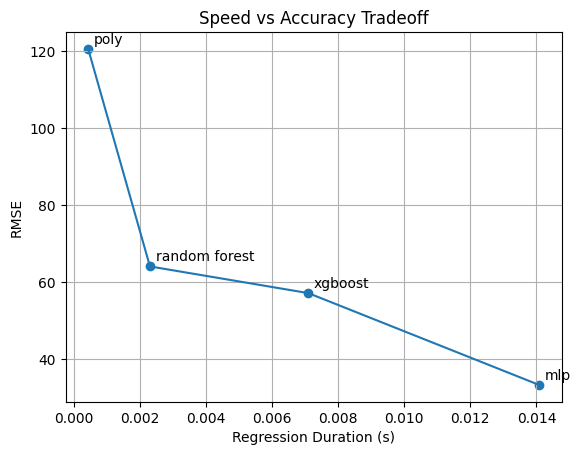

In [69]:
plt.plot(speed_results['Average Total Regression Time per Timestep'], speed_results['RMSE'])
plt.scatter(speed_results['Average Total Regression Time per Timestep'], speed_results['RMSE'])
for i, row in speed_results.iterrows():
    plt.annotate(row['Model'], (row['Average Total Regression Time per Timestep'], row['RMSE']), xytext=(4, 4), textcoords='offset points')
plt.xlabel('Regression Duration (s)')
plt.ylabel('RMSE')
plt.title('Speed vs Accuracy Tradeoff')
plt.grid(True) 
plt.show()

This plot shows the evident tradeoff with ML models. The more accurate models tend to be, the longer they tend to take to perform their tasks. Understanding this trend is crucial for choosing the right models for different scenarios. **For more complex derivative pricing that might require a more robust model, MLP would be a good fit**. Furthermore, despite having the longest overall regression time, MLP predicts faster than the other models. This may make MLP the clear pick in a setting where the model does not to be trained at every timestep, like I did in the LS algorithm. **Polynomial Regression may be still preferred in ultra-low latency environments**, where quick and rough estimates are the most viable forms of data. **Tree-based models exist as a good in between** with various different applications.

There is **no clear winner** in terms of which model is the best to price American options using the LS algorithm. But I had fun tuning these models with both finanical and ML theory to understand how the combination of two will optiimze the field of quantititive finance for years to come.

***Thanks for reading!***